# COVIDcast Data Smoothing
In this document, we compare different methods of smoothing [COVIDcast signals](https://github.com/cmu-delphi/delphi-epidata/blob/e7cd1012d2046980571a3ded6db6803f64e4506b/docs/api/covidcast_signals.md). See the README.md file for the problem statement and the mathematical background.

The dependencies are listed below. Note that `covidcast` and `delphi_utils` from [this branch](https://github.com/cmu-delphi/covidcast-indicators/tree/dev-smoothing) should be installed in your python environment.

In [1]:
import os
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import covidcast
from delphi_utils import Smoother

## An Example: California Google Health Trends
To begin, let's load a raw example signal, say the [Google Health Trends signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/ght.md) `ght` which records Google search activity.

In [2]:
filename = "ght_raw.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="state", geo_values="ca")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

Let's look at how the smoothers work on this signal.

Recall that `left_gauss_linear` has a dynamic window, fits a line through the data, weighing the recent 3 weeks most heavily. `savgol` has a sharp cutoff at 6 weeks, the same weighing, but fits a second-degree polynomial. As we can see in the plot below, `savgol` is a bit more noisy.

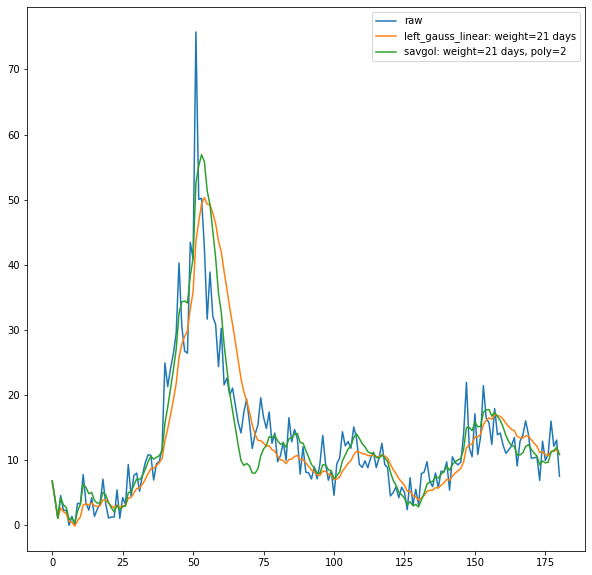

In [3]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother()
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2")
plt.legend()

If we don't weigh `savgol` at all (recall it still has the 6 week cutoff), it has occasional large deviations phenomena around large peaks. For this reason, it's better to use the Gaussian weights.

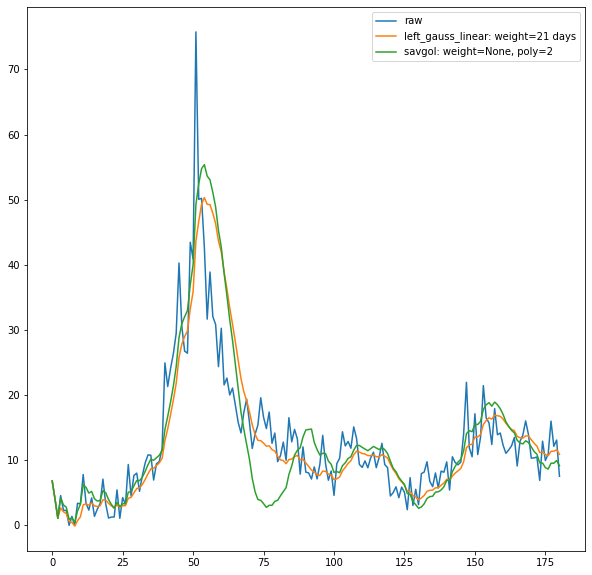

In [4]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother(gaussian_bandwidth=None)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=None, poly=2")
plt.legend()

Bringing the weights back, let's reduce the weighing window. We can make a correspondence between bandwidth and the weighing window by solving
$$\int_0^w F(x, \sigma) dx = 0.9,$$
where $F$ is PDF of a Gaussian with mean 0, variance $\sigma^2$, for $\sigma$ for a given $w$ (in days).
This gives us following correspondence between window length and bandwidth units:

- 7 days ~ 36
- 14 days ~ 144
- 21 days ~ 325
- 28 days ~ 600

Reducing weight center to 14 days and 21 days, yields the following. The 14 day window looks smoother to me. 

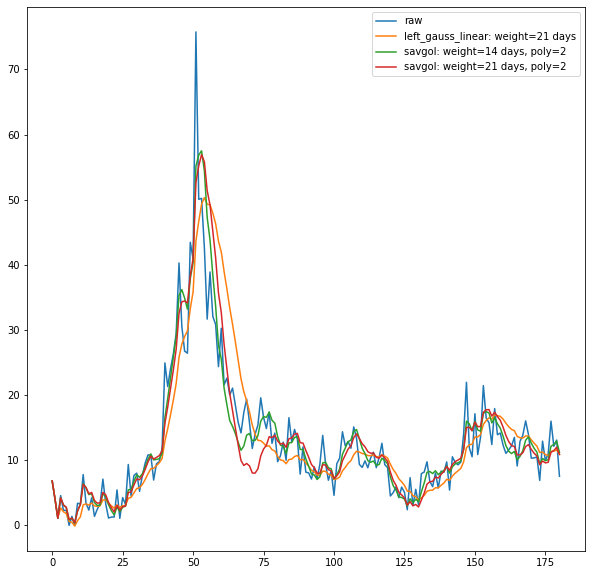

In [5]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother(gaussian_bandwidth=144)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=2")
smoother = Smoother(gaussian_bandwidth=325)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2")
plt.legend()

Increasing the degree of the polynomial fit passes through more noise. It seems best to stay away from making this higher than 2 (we will see below that 0 is a good setting in the sparse regime).

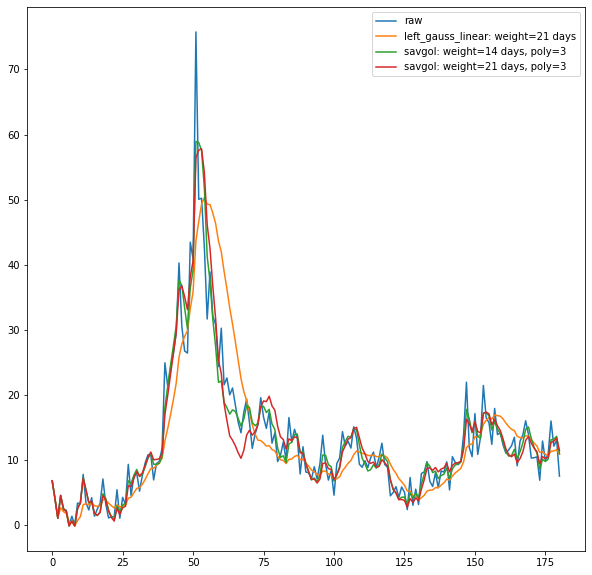

In [6]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother(gaussian_bandwidth=144, poly_fit_degree=3)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=3")
smoother = Smoother(gaussian_bandwidth=325, poly_fit_degree=3)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=3")
plt.legend()

Note that `savgol` with polynomial degree 1 is almost identical to `left_gauss_linear`. The difference is that `left_gauss_linear` uses the full past window, but most of those terms are negligible. In a future iteration, we should deprecate the latter. The reason to keep them separate now is to keep the past implementation as a point of reference.

In [7]:
lgl_smoother = Smoother(method_name='left_gauss_linear')
sg_smoother = Smoother(poly_fit_degree=1)
np.allclose(sg_smoother.smooth(np.array(data_raw.value)), lgl_smoother.smooth(np.array(data_raw.value)), atol=2)

True

## Sparse data
There tends to be less data at the county level and therefore a lot more zeros. We want our smoothers to work well in these situations.

Let's take a look at `ght` again, in the hospital regions around Pittsburgh and Sacramento.

In [8]:
filename = "ght_raw_hrr_pittsburgh.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="hrr", geo_values="357")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

`left_gauss_linear` seems to be work fine, `savgol` is more sensitive with its higher degree fit.

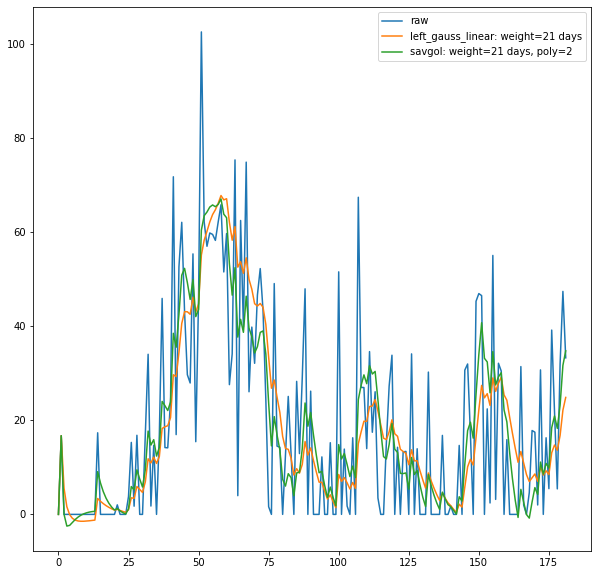

In [9]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother()
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2")
plt.legend()

We can smooth both out with a higher bandwidth. `savgol` is less noisy than before, but I still think `left_gauss_linear` looks better.

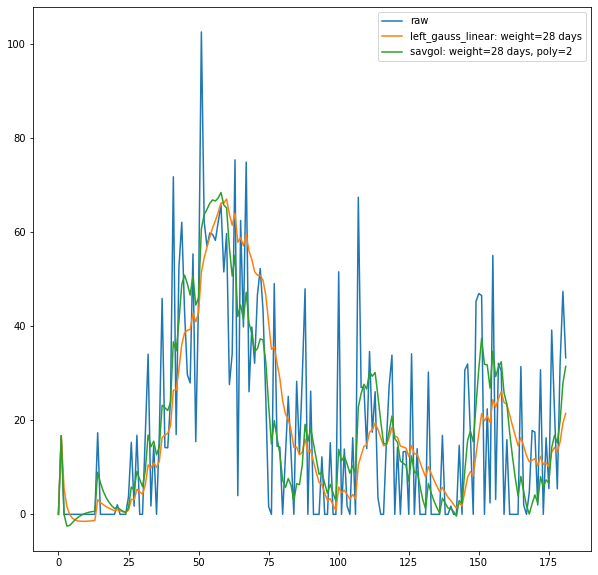

In [10]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=28 days")
smoother = Smoother(gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=28 days, poly=2")
plt.legend()

Recalling that `savgol` will only get more sensitive with a higher polynomial degree, let's explore setting it to 0. 

Aha! Here we get something even smoother, but the catch is that the bandwidth has to be lowered to two weeks. If the bandwidth is too high, the smoother lags behind the data like a moving window average. 

This looks like a promising setting for `savgol` in the sparse regime.

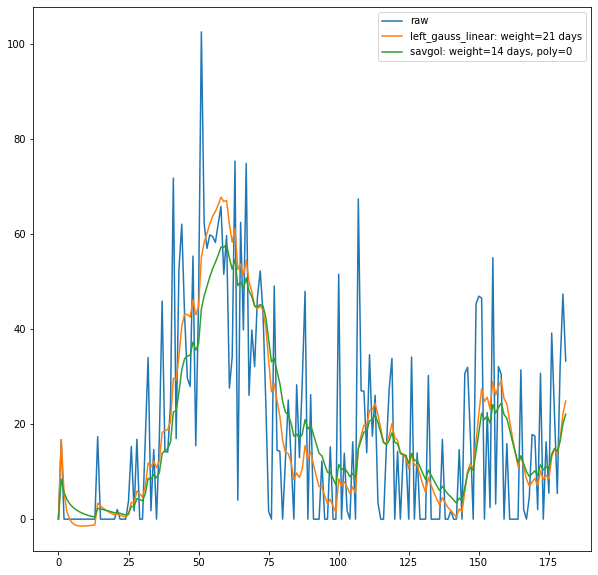

In [11]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother(gaussian_bandwidth=100, poly_fit_degree=0)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

Let's look at another hospital region. Sacramento.

In [12]:
filename = "ght_raw_hrr_sacramento.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal("ght", "raw_search", 
                                start_day=None, end_day=None,
                                geo_type="hrr", geo_values="77")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

Again, using the polynomial fit degree of zero, we can get something with smaller zigzags. However, the peaks in the data are not represented as well. This may be fine -- if the data peaks reflect reporting phenomena (batching), then this is exactly what we want the smoother to disentangle.

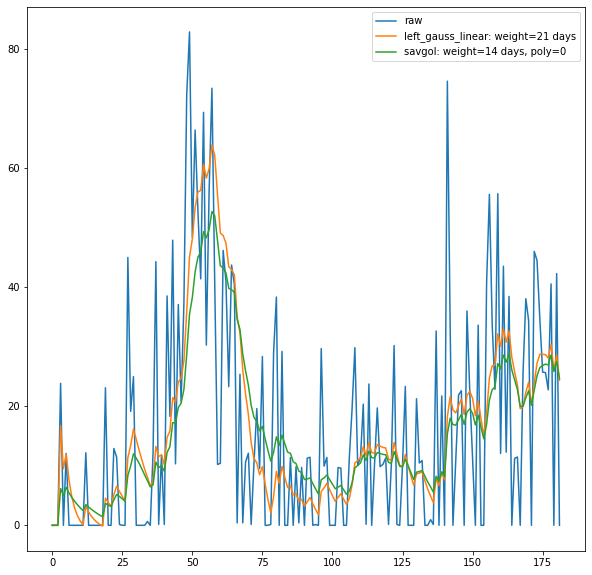

In [13]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother(gaussian_bandwidth=100, poly_fit_degree=0)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

Just to test, let's try polynomial degree 2 again. Of course, very sensitive.

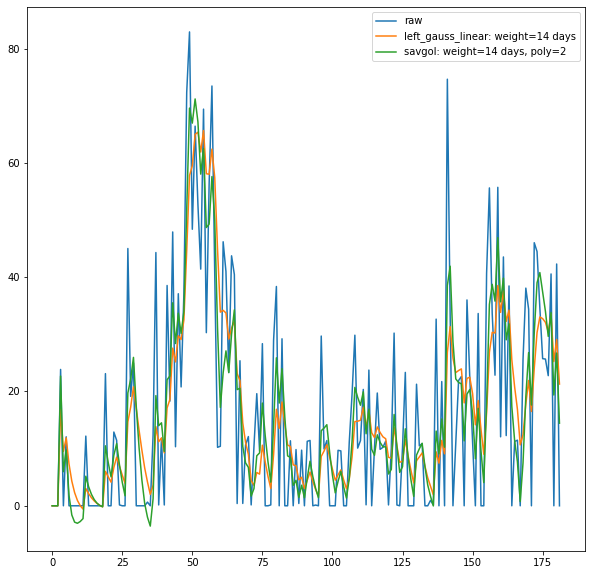

In [14]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=14 days")
smoother = Smoother(gaussian_bandwidth=100, poly_fit_degree=2)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=2")
plt.legend()

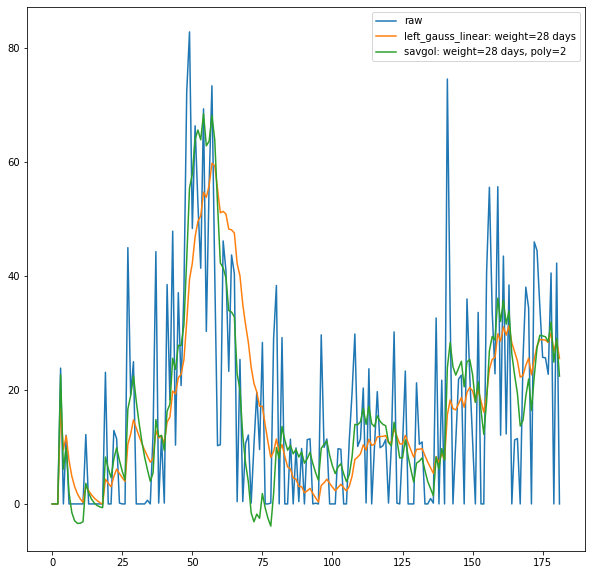

In [15]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=28 days")
smoother = Smoother(gaussian_bandwidth=600, poly_fit_degree=2)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=28 days, poly=2")
plt.legend()

Let's take a look at a different indicator, `jhu-csse`.

In [16]:
filename = "jhu_confirmed_incidence_hrr_sacramento.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal(data_source="jhu-csse", 
                                signal="confirmed_incidence_num", 
                                start_day=None, 
                                end_day=None, 
                                geo_type="hrr", 
                                geo_values="77")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

The same pattern: `savgol` is more sensitive to noise, but when set to polynomial degree 0 becomes quite resistant.

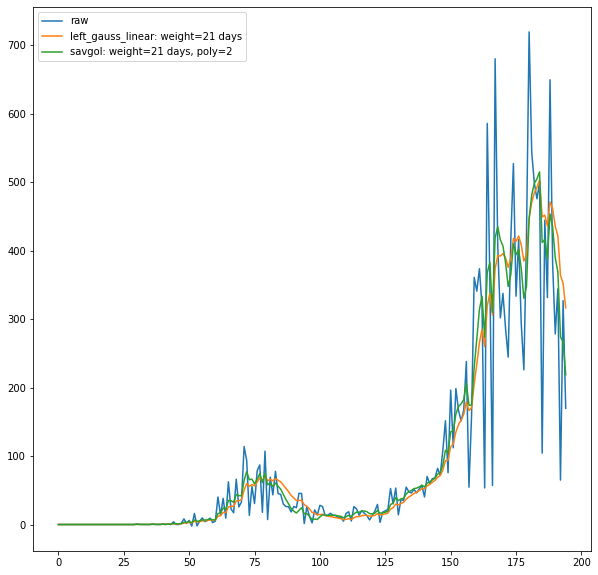

In [17]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother()
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2")
plt.legend()

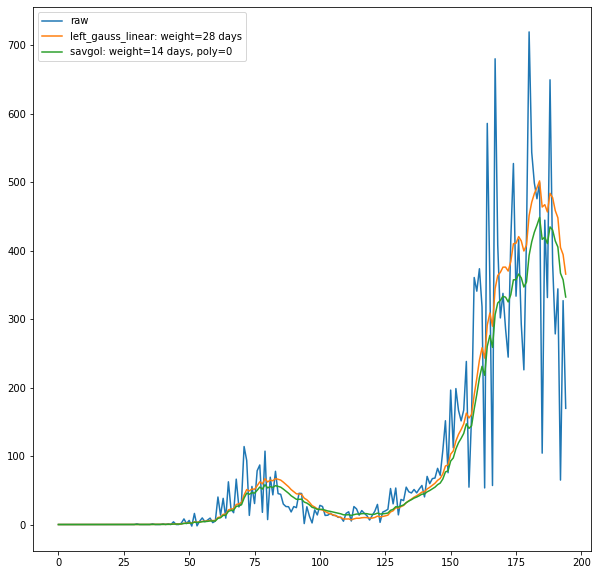

In [18]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=28 days")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

Now Pittsburgh.

In [19]:
filename = "jhu_confirmed_incidence_hrr_pittsburgh.csv"
if filename not in os.listdir():
    data_raw = covidcast.signal(data_source="jhu-csse", 
                                signal="confirmed_incidence_num", 
                                start_day=None, 
                                end_day=None, 
                                geo_type="hrr", 
                                geo_values="357")
    data_raw.to_csv(filename)
else:
    data_raw = pd.read_csv(filename)

Same pattern.

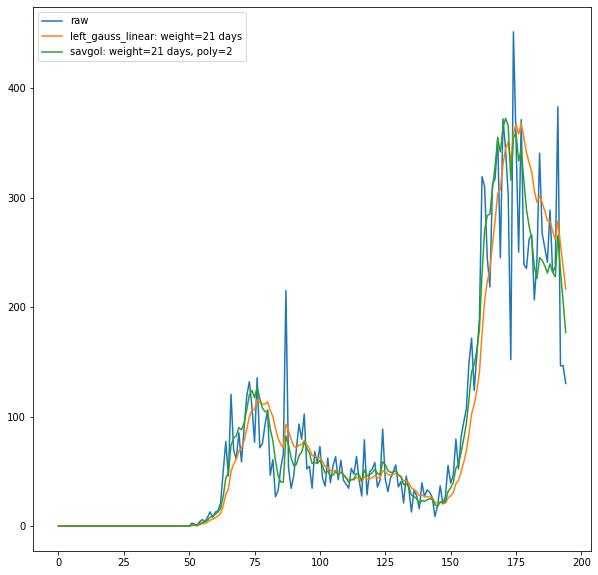

In [20]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear')
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=21 days")
smoother = Smoother()
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=21 days, poly=2")
plt.legend()

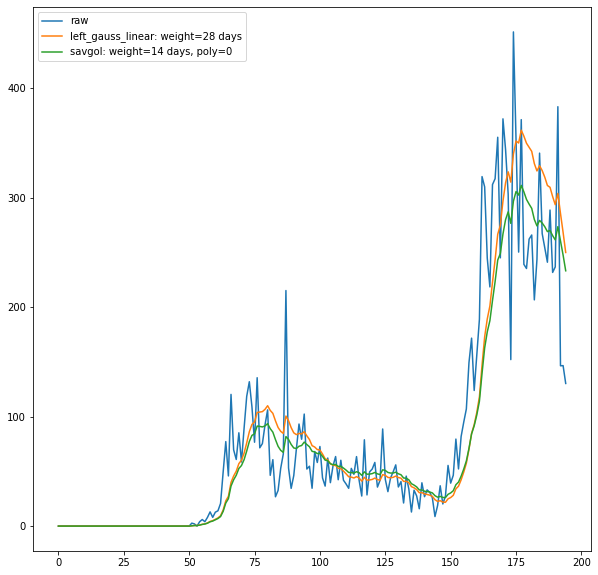

In [21]:
plt.figure(figsize=(10,10))
plt.plot(np.array(data_raw.value), label="raw")
smoother = Smoother(method_name='left_gauss_linear', gaussian_bandwidth=600)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="left_gauss_linear: weight=28 days")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=100)
plt.plot(smoother.smooth(np.array(data_raw.value)), label="savgol: weight=14 days, poly=0")
plt.legend()

## Simulated zero-censored data

We can also simulate censored data. This is to be explored more fully later.

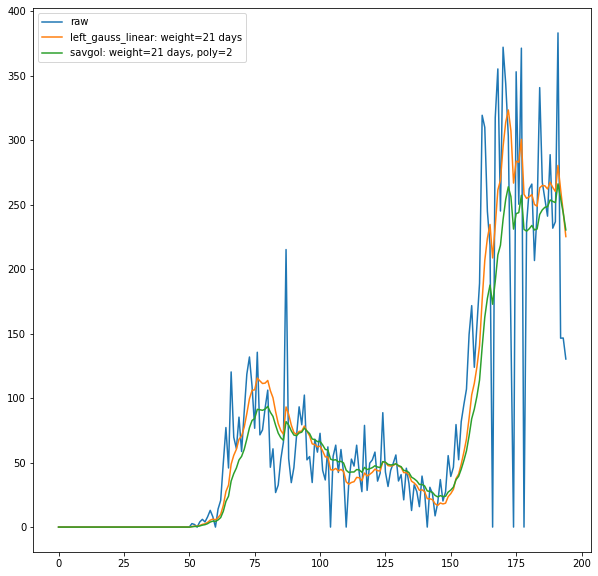

In [22]:
def censor_data(x, n):
    """
    Randomly zero out n values from the array.
    """
    for i in range(n):
        ix = np.random.randint(len(x))
        x[ix] = 0
    return x

data_censored = censor_data(np.array(data_raw.value), 10)
plt.figure(figsize=(10,10))
plt.plot(data_censored, label="raw")
smoother = Smoother('left_gauss_linear')
plt.plot(smoother.smooth(data_censored), label="left_gauss_linear: weight=21 days")
smoother = Smoother(poly_fit_degree=0, gaussian_bandwidth=100)
plt.plot(smoother.smooth(data_censored), label="savgol: weight=21 days, poly=2")
plt.legend()

## Other Signals
Many of the other signals had obstacles to a clear comparison.

- The `doctor-visits` and `hospital-admissions` [signal](https://github.com/cmu-delphi/delphi-epidata/blob/main/docs/api/covidcast-signals/doctor-visits.md) are already smoothed by the provider. The raw data does not appear to be available.
- The `fb-survey` and `google-survey` signal require access to the survey data. 